Backbone to plot PETHs of PL neurons around the time of the CS for a single rat.

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import os

if os.environ['SHELL'] == '/bin/zsh':  # Laptop/Mac
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/TraceFC/')
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/NeuroPy/')
elif os.environ['SHELL'] in ['/bin/sh', '/bin/bash']:  # Linux desktop
    sys.path.append('/data/GitHub/TraceFC/')
    sys.path.append('/data/GitHub/NeuroPy/')
%load_ext autoreload
%autoreload 2

from neuropy.plotting.ca_events import plot_pe_traces, Raster
from neuropy.io.minianio import MinianIO
import session_directory as sd
from neuropy.analyses.trace_fc import load_events_from_csv
from neuropy.core.ca_neurons import CaNeuronReg, PairwiseMap, MultiSessionMap, CaNeurons, load_pairwise_map
from neuropy.utils.plot_util import sparse_axes_labels
from traceio import load_trace_events

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set up everything for plotting

## NRK todo: move this function into trace_fc github repo

In [2]:
def get_events():
    """Function to grab events of a certain type from a .csv file"""
    pass

/home/nkinsky/miniconda3/envs/NeuroPy/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniconda3/envs/NeuroPy/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Below needs to be more general - should be able to plot into any axes.

In [3]:
def plot_CS_PETH(sesh_dir, caneurons, session, csname, processed='C', raw='YrA', 
                 neuron_inds: list or np.ndarray or None = None):
    """Plot neural"""
    event_starts, event_ends = load_trace_events(str(sesh_dir), session, csname)
    
    # Grab traces
    proc_traces = getattr(caneurons, processed)
    raw_traces = getattr(caneurons, raw)
    if neuron_inds is not None: # Trim down and re-order if specified
        proc_traces = proc_traces[neuron_inds]
        raw_traces = raw_traces[neuron_inds]
        
    for idc, (proc_trace, raw_trace) in enumerate(zip(proc_traces, raw_traces)):

        fig, ax, _, _, _ = plot_pe_traces(caneurons.t['Timestamps'], proc_trace, event_starts['Timestamp'], 
                                        event_ends=event_ends['Timestamp'], 
                                        raw_trace=raw_trace, end_buffer_sec=40)
        [a.axvline(30, color='r', linestyle='--') for a in ax]
        [a.set_title(f'{csname}: Cell #{idc}') for a in ax]
        fig.suptitle(' '.join(session.capitalize().split('_')))

In [4]:
def create_peth_and_raster_axes(nrows, ncols, height_ratio=(3, 1)):
    """Create alternating rows of axes for PETH traces and corresponding rasters below"""
    fig = plt.figure(figsize=(8.5, 4*nrows))
    gs = fig.add_gridspec(nrows*2, ncols, height_ratios=height_ratio*nrows)
    ax, axrast = [], []
    for idr in range(nrows):
        axcol, axcolrast = [], []
        for idc in range(ncols):
            axcol.append(fig.add_subplot(gs[idr*2, idc]))
            axcolrast.append(fig.add_subplot(gs[idr*2 + 1, idc]))
        ax.append(axcol)
        axrast.append(axcolrast)
    ax = np.array(ax)
    axrast = np.array(axrast)
    
    return fig, ax, axrast

In [5]:
# NRK make this work for neuron_inds as list or pd.DataFrame
def plot_paired_CS_PETH(caneurons: list, event_starts: list, event_ends: list, 
                        var_plot: str in ['YrA', 'C', 'S'], neuron_inds: list, 
                        cs_types: list, sesh_names: list, 
                        cs_color=np.array([1, 0.647, 0, 0.3]), plot_rast=False,
                       **kwargs):
    """**kwargs to seaborn.heatmap()"""
    
    if np.array(cs_color).ndim == 1:
        cs_color = np.array(cs_color).reshape(1, -1).repeat(len(caneurons), axis=0)
    
    # Check inputs
    ninds = [len(inds) for inds in neuron_inds]
    assert np.array([n == ninds[0] for n in ninds]).all(), '# inds in neuron_inds input must all be the same'
    neuron_inds = np.array(neuron_inds)
        
    # Set up plot
    ncols = len(caneurons)
    nrows = len(neuron_inds[0])
    if not plot_rast:
        fig, ax = plt.subplots(nrows, ncols, figsize=(8.5, 3*nrows))
    else:
        fig, ax, axrast = create_peth_and_raster_axes(nrows, ncols)
        
    for ids, (caneuron, starts, ends, inds, color) in enumerate(zip(caneurons, event_starts, event_ends, 
                                                                    neuron_inds, cs_color)):
        traces_plot = getattr(caneuron, var_plot)[inds]
        cs_name = cs_types[ids]
        sesh_name = sesh_names[ids]
        for idc, trace in enumerate(traces_plot):
            _, _, rast, _, _ = plot_pe_traces(caneuron.t["Timestamps"], trace, 
                                            event_starts=starts["Timestamp"], 
                                            event_ends=ends["Timestamp"],
                                            event_color=color, raw_trace=None, 
                                            end_buffer_sec=40, ax=ax[idc, ids])
            # Plot raster if specified
            if plot_rast:
                sns.heatmap(rast, ax=axrast[idc, ids],**kwargs)
                sns.despine(ax=axrast[idc, ids])
                axrast[idc, 0].set_ylabel('Trials')
                axrast[idc, ids].set(xticks=[], xticklabels=[])
                sparse_axes_labels(axrast[idc, ids], 'y')
            
            
            ax[idc, ids].set_title(f'{sesh_name}: {cs_name} Cell #{idc}')
        [a.axvline(30, color='r', linestyle='--') for a in ax[:, ids]]
    
    # Turn off redundant and overlapping ylabels
    [a.set_ylabel('') for a in ax[:, 1:].reshape(-1)]
    
    # Make font smaller so that you can read titles
    [a.set_title(a.get_title(), fontdict={'fontsize':8}) for a in ax.reshape(-1)]
        
    # overwrite inds == -1 with a blank plot with an x through it.
    silent_bool = neuron_inds.T == -1
    for a in ax[silent_bool].reshape(-1):
        a.clear()
        sns.despine(ax=a, bottom=True, left=True)
        a.set(xticks=[], yticks=[])
    if plot_rast:
        for a in axrast[silent_bool].reshape(-1):
            a.clear()
            sns.despine(ax=a, bottom=True, left=True)
            a.set(xticks=[], yticks=[])
        
    
    return fig, ax

In [31]:
import itertools

# Specify sessions to plot here
animal = 'Rey' #'Jyn' # 'Rat698' # 'Rose' # 'Rey' 
sessions = ['Habituation2', 'Training', 'Recall1']
keep = [['good', 'maybe_interneurons']]*len(sessions)
trim = [None]*len(sessions)

if animal == 'Finn':
    keep[1] = None
    trim[1] = 'bad_units'  
# Assemble data
careg = CaNeuronReg([MinianIO(basedir=sd.get_session_dir(animal, session)).trim_neurons(keep=ke, trim=tr) 
                     for session, ke, tr in zip(sessions, keep, trim)], alias=sessions)

# Assemble maps
msm = MultiSessionMap(pwmaps=[careg.load_pairwise_map(sesh1, sesh2) for sesh1, sesh2 in 
                       itertools.combinations(sessions, 2)], sesh_order=sessions)

# Get full map for all sessions
multi_sesh_map = msm.stepwise_reg(overwrite_indirect=True)

Keeping 35589 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 15_57_51 folder.
Keeping 128405 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 12_44_15 folder.
Keeping 46637 good frames found in "good_frames_bool.npy" file


## Now loop through and plot things

## NRK put in ROI overlaid plot here

In [32]:
# First get coactive neurons
coactive_bool = (multi_sesh_map > -1).sum(axis=1) >= 2
coactive_map = multi_sesh_map[coactive_bool]
ncoactive = coactive_map.shape[0]
coactive_map

,Habituation2,Training,Recall1
0,0,-1,2
1,1,-1,0
3,3,1,3
4,4,0,1
6,6,2,4
7,7,-1,6
10,10,10,13
11,11,9,-1
12,12,11,17
14,14,13,16


In [33]:
## NRK streamline this - should be able to infer some of these variables from other inputs above - will cut down
# on future errors - should be able to at leas get session_type and color!
if animal != 'Rat698':
    cs_types = ['CS-', 'CS+', 'CS+', 'CS-']
    session_types = ['tone_habituation', 'training', 'tone_recall', 'control_tone_recall']
    sessions_use = ['Habituation2', 'Training', 'Recall1', 'Recall1']
    events = [load_trace_events(sd.get_session_dir(animal, session), sesh_type, cs_type) 
              for session, sesh_type, cs_type in zip(sessions_use, session_types, cs_types)]
    colors = [[1, 0.647, 0, 0.3]]*(len(session_types) - 1)
    colors[0] = [0, 1, 0, 0.3]
    colors.append([0, 1, 0, 0.3])
elif animal == 'Rat698':
    cs_types = ['CS+', 'CS+']
    session_types = ['training', 'tone_recall']
    sessions_use = ['Training', 'Recall1']
    events = [load_trace_events(sd.get_session_dir(animal, session), sesh_type, cs_type) 
              for session, sesh_type, cs_type in zip(sessions_use, session_types, cs_types)]
map_use = coactive_map[sessions_use]
caneurons_use = [careg.get_session(sesh) for sesh in sessions_use]

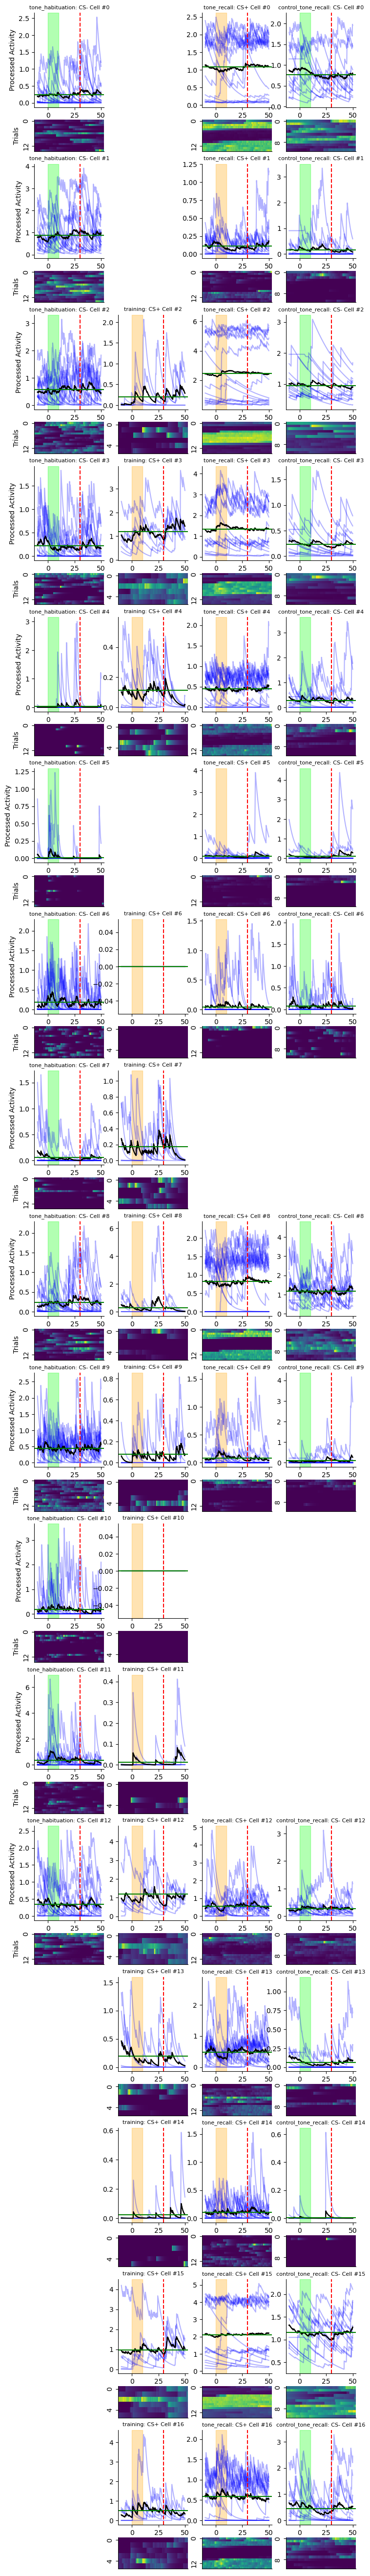

In [34]:
# map_use = map_use.iloc[0:5,:]  # test out code quickly using this
fig, ax = plot_paired_CS_PETH(caneurons_use, event_starts=[event[0] for event in events], 
                    event_ends=[event[1] for event in events], var_plot='C', 
                    neuron_inds=map_use.values.T, cs_types=cs_types, sesh_names=session_types,
                    cs_color=colors, plot_rast=True, cbar=False, cmap='viridis',
                    rasterized=True)

In [35]:
# Save figure to first session in list.
fig.savefig(careg.get_session(sessions[0]).basedir / f'{animal}_{sessions[0]}_{sessions[1]}_{sessions[2]}_CSplots.pdf')

In [30]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

## NRK todo:  

~~1) automate loading in events file - concatenate if there are multiple, should be easy to filter out and ignore post-hoc with pandas indexing  ~~
  
~~2) Filter out bad neurons - use "curated_neurons.pkl" file to grab only good ones~~

~~3) Debug RunTimeWarning above~~

4) turn plotting function a function on its own? Maybe keep in notebook for now and just run three separate cells? Yes.

5) Plot each neuron's activity side-by-side across all three conditions.

6) Plot across days - during training, during shock, and during recall1.

7) Fold code bits above into trace_fc class for easier access!!!
